# Model Building

putting it all togather

## Setting up

In [1]:
import os, sys
import random
import warnings

import logging
# logging.basicConfig(filename='modeling.log', filemode='a', format='%(name)s - %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger()
handler = logging.FileHandler('modeling.log', mode='a')
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

logger.log(logging.INFO, 'Started modeling.py')

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#For the plots
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

from sklearn import set_config

set_config(display="diagram")

C:\Users\akshu\.conda\envs\ml\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


set random reed

In [2]:
random_state = 42
# np.random.seed = random_state
rng = np.random.default_rng(random_state)

In [3]:
train = pd.read_csv('../data/processed/train.csv')
train.drop(['id'], inplace=True, axis=1)

test = pd.read_csv('../data/processed/test.csv')
test.drop(['id'], inplace=True, axis=1)

## Importing Data

In [4]:
col_y = 'song_popularity'

X = train.copy()
y = X.pop(col_y)

In [5]:
mask = X.nunique() < 15
categorical_cols = X.columns[mask]
numerical_cols = [col for col in X.columns if col not in categorical_cols]

In [6]:
# convert audio_mode, key & time_signature column values to categorical
X['key'] = X['key'].astype( "Int64")
X[categorical_cols] = X[categorical_cols].astype('category')
X = pd.get_dummies(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_duration_ms  35899 non-null  float64
 1   acousticness      36008 non-null  float64
 2   danceability      35974 non-null  float64
 3   energy            36025 non-null  float64
 4   instrumentalness  36015 non-null  float64
 5   liveness          35914 non-null  float64
 6   loudness          36043 non-null  float64
 7   speechiness       40000 non-null  float64
 8   tempo             40000 non-null  float64
 9   audio_valence     40000 non-null  float64
 10  key_0             40000 non-null  uint8  
 11  key_1             40000 non-null  uint8  
 12  key_2             40000 non-null  uint8  
 13  key_3             40000 non-null  uint8  
 14  key_4             40000 non-null  uint8  
 15  key_5             40000 non-null  uint8  
 16  key_6             40000 non-null  uint8 

# Splitting data

In [7]:
# split the dataset in train, validation & test sets
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=random_state, stratify=y_train_full)

In [8]:
X_train_full.shape, X_train.shape, X_val.shape, X_test.shape

((32000, 28), (25600, 28), (6400, 28), (8000, 28))

## Importing modeling & pre/post-processing libraries

In [9]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.experimental import enable_iterative_imputer, enable_halving_search_cv
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator, IterativeImputer, MissingIndicator
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, MinMaxScaler, PowerTransformer, RobustScaler, power_transform, minmax_scale
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, classification_report

# import classifier models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier, BaggingClassifier, StackingClassifier
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, LogisticRegressionCV, SGDClassifier, SGDRegressor, Ridge, LassoLarsCV, LassoLars, RidgeCV, BayesianRidge
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import SVC, NuSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis


sys.path.append("kuma_utils/")
from kuma_utils.preprocessing.imputer import LGBMImputer

## building Preprocessors

In [10]:
# columns used for inverse sigmoid transformation
from sklearn.preprocessing import MinMaxScaler, minmax_scale, PowerTransformer, FunctionTransformer
# from sklearn_pandas import DataFrameMapper

col_sig = [
    'acousticness',
    'danceability',
    'energy',
    'instrumentalness',
    'liveness',
    'speechiness',
    'audio_valence',
]

col_pow = [
    'song_duration_ms',
    'tempo',
]

# make a custom transformer to transform the data
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.base import BaseEstimator, TransformerMixin

class PreProcessorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols, show_impute=False, inplace=False):
        self.show_impute = show_impute
        self.inplace = inplace
        self.col_sig, self.col_pow, self.loudness = cols
        self.cols = self.col_sig + self.col_pow
        self.inv_sigmoid = FunctionTransformer(lambda x: np.log(x / (1-x)))
        self.loudness_transformer = FunctionTransformer(lambda x: np.log1p(-x))
        
    def fit(self, X, y=None):
        if type(X) is tuple:
            X = X[0]
            
        self.scaler = MinMaxScaler(feature_range=(0+1e-6, 1-1e-6)).fit(X[self.col_sig])
        
        X_tmp = X[self.col_sig+self.col_pow].copy()
        X_tmp[self.col_sig] = self.scaler.transform(X_tmp[self.col_sig])
        X_tmp[self.col_sig] = self.inv_sigmoid.fit_transform(X_tmp[self.col_sig])
        
        self.transformer = PowerTransformer().fit(X_tmp)

        return self
    
    def transform(self, X):

        if not self.inplace:
            X = X.copy()

        X[self.col_sig] = self.scaler.transform(X[self.col_sig])
        X[self.col_sig] = self.inv_sigmoid.fit_transform(X[self.col_sig])
    #    # Box-Cox transformation
        X[self.col_sig+self.col_pow] = self.transformer.transform(X[self.col_sig+self.col_pow])
        X[self.loudness] = self.loudness_transformer.fit_transform(X[self.loudness])
        
        return X

    def fit_transform(self, X, y=None):
        if type(X) is tuple:
            X = X[0]
        
        self.fit(X, y)
        
        return self.transform(X) if y is None else (self.transform(X), y)

class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, outlier_remover, **kwrgs):
        self.outlier_remover = outlier_remover(**kwrgs)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        y_hat = self.outlier_remover.fit_predict(X)
        mask = y_hat != -1
        
        if y is None:
            return X.iloc[mask, :]
        else:
            return X.iloc[mask, :], y[mask]

    def fit_transform(self, X, y=None):
        if type(X) is tuple:
            X = X[0]
        
        self.fit(X, y)
        
        return self.transform(X, y)

class Imputer(BaseEstimator, TransformerMixin):
    def __init__(self, imputer, **kwrgs):
        self.add_indicator = kwrgs.get('add_indicator', False)
        self.imputer = imputer(**kwrgs)

    def fit(self, X, y=None):
        col = X.columns
        if self.add_indicator:
            mask = X.isna().any(axis=0)
            self.imputed_col_names = col.tolist()+["_"+col+"_imputed_" for col in mask[mask].index]
        else:
            self.imputed_col_names = col

        return self


    def transform(self, X):
        train_knnimp = self.imputer.fit_transform(X)
        X = pd.DataFrame(train_knnimp, columns=self.imputed_col_names)
        
        return X

    def fit_transform(self, X, y=None):
        if type(X) is tuple:
            X = X[0]

        self.fit(X, y)
        
        return self.transform(X) if y is None else (self.transform(X), y)


imputer = Imputer(IterativeImputer, add_indicator=True, max_iter=10)
transformer = PreProcessorTransformer([col_sig, col_pow, 'loudness'])
outlier_remover = OutlierRemover(LocalOutlierFactor, n_neighbors=20, contamination=0.02)

In [11]:
preprocessor_pipe = Pipeline([
    ("na-imputation", imputer),
    ("transformation", transformer),
    ('outlier remover', outlier_remover),
])
preprocessor_pipe

Pipeline(steps=[('na-imputation',
                 Imputer(imputer=IterativeImputer(add_indicator=True))),
                ('transformation',
                 PreProcessorTransformer(cols=['acousticness', 'danceability',
                                               'energy', 'instrumentalness',
                                               'liveness', 'speechiness',
                                               'audio_valence',
                                               'song_duration_ms', 'tempo'])),
                ('outlier remover',
                 OutlierRemover(outlier_remover=LocalOutlierFactor(contamination=0.02)))])

### Custom transformations for each column

#### Descritizing `instrumentalness`

In [12]:
from sklearn.cluster import KMeans

# for modeling
class Descretizer(BaseEstimator, TransformerMixin):
    def __init__(self, descritizer, variable, inplace=False, **kwrgs):
        self.variable = variable
        self.inplace = inplace
        self.descritizer = descritizer(**kwrgs)

    def fit(self, X, y=None):
        self.descritizer.fit(X[[self.variable]])
        
        return self


    def transform(self, X):
        if self.inplace:
            X[self.variable] = self.descritizer.predict(X[[self.variable]])
        else:
            X[self.variable+"_descrete"] = self.descritizer.predict(X[[self.variable]])

        return pd.get_dummies(X)

    def fit_transform(self, X, y=None):
        if type(X) is tuple:
            X = X[0]
            
        self.fit(X, y)
        
        return self.transform(X) if y is None else (self.transform(X), y)

In [13]:
descretizer = Descretizer(KMeans, 'instrumentalness', True, n_clusters=5, random_state=0)

pipe = Pipeline([
    ('preprocessor_pipe', preprocessor_pipe),
    ('descretizer_pipe', descretizer),
])
pipe

Pipeline(steps=[('preprocessor_pipe',
                 Pipeline(steps=[('na-imputation',
                                  Imputer(imputer=IterativeImputer(add_indicator=True))),
                                 ('transformation',
                                  PreProcessorTransformer(cols=['acousticness',
                                                                'danceability',
                                                                'energy',
                                                                'instrumentalness',
                                                                'liveness',
                                                                'speechiness',
                                                                'audio_valence',
                                                                'song_duration_ms',
                                                                'tempo'])),
                                 ('outlier remover',
                                  OutlierRemover(outlier_remover=LocalOutlierFactor(contamination=0.02)))])),
                ('descretizer_pipe',
                 Descretizer(descritizer=KMeans(n_clusters=5, random_state=0),
                             inplace=True, variable='instrumentalness'))])

In [14]:
# # pipe.fit(X_train_full, y_train_full)
# X_train_preprocessed, y_train_preprocessed = pipe.fit_transform(X_train_full, y_train_full)
# X_train_preprocessed = RobustScaler().fit_transform(X_train_preprocessed)

In [15]:
preprocessor_pipe = Pipeline([
    ("na-imputation", imputer),
    ("transformation", transformer),
])

preprocessor_pipe.fit(X_train_full)
X_preprocessed = preprocessor_pipe.transform(X_train_full)

outlier_remover = OutlierRemover(LocalOutlierFactor, n_neighbors=20, contamination=0.02)
outlier_remover.fit(X_preprocessed, y_train_full)
X_train_preprocessed, y_train_preprocessed = outlier_remover.transform(X_preprocessed, y_train_full)

descretizer = Descretizer(KMeans, 'instrumentalness', True, n_clusters=5, random_state=0)
descretizer.fit(X_train_preprocessed)
X_train_preprocessed = descretizer.transform(X_train_preprocessed)

In [16]:
X_train_preprocessed.shape, y_train_preprocessed.shape, X_train_full.shape, y_train_full.shape

((31360, 35), (31360,), (32000, 28), (32000,))

# Model selection

brute force through all models: the worst possible way

In [17]:
# !pip install lazypredict
# !pip install ml-model-selection

In [18]:
# from model_selection import models_validation, hyperparameters_validation

import sys
sys.path.append( '../' )

from models.model_selection import models_validation, hyperparameters_validation

# model_paramGrid_list = [
#                             ("NB", GaussianNB(), {}),
#                             ("RidgeClassifierCV", RidgeClassifierCV(), {}),
#                             ("LassoCV", LassoCV(), {}),
#                             ("ElasticNet", ElasticNet(), {}),
#                             ("ElasticNetCV", ElasticNetCV(), {}),
#                             ("LogisticRegressionCV", LogisticRegressionCV(), {}),
#                             ("SGDClassifier", SGDClassifier(early_stopping=True), {}),
#                             ("RidgeCV", RidgeCV(), {}),
#                             ("LassoCV", LassoCV(), {}),
#                             ("LassoLarsCV", LassoLarsCV(), {}),
#                             ("BayesianRidge", BayesianRidge(), {}),
#                             ("SVC", SVC(), {}),                 
#                             ("KNN", KNeighborsClassifier(), {}),
#                             ("DT", DecisionTreeClassifier(), {}),
#                             ("RF", RandomForestClassifier(), {}),
#                             ("ETC", ExtraTreeClassifier(), {}),
#                             ("GB", GradientBoostingClassifier(), {}),
#                             ("AB", AdaBoostClassifier(), {}),
#                        ]

model_paramGrid_list = [
                            # ("NB", GaussianNB(), {}),
                            # ("RidgeClassifierCV", RidgeClassifierCV(), {
                            #   # "alphas" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                            #                                               "fit_intercept" : [True, False],
                            #                                               "normalize" : [True, False],
                            #                                               "scoring" : ["accuracy", "f1_macro", "f1_micro", "f1_weighted", "precision_macro", "precision_micro", "precision_weighted", "recall_macro", "recall_micro", "recall_weighted", "roc_auc"],
                            #                                             "class_weight" : ["balanced", None],
                            #                                             "store_cv_values" : [True, False],}),
                            ("LassoCV", LassoCV(n_jobs=-1, cv=5), {
                              # "alphas" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                    # "cv" : [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                                                    "eps" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                    "n_alphas": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                                                    "fit_intercept" : [True, False],
                                                    "normalize" : [True, False],
                                                    "precompute" : [True, False],
                                                    "max_iter" : [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                                                    "tol" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                    "verbose" : [True, False],
                                                    "positive" : [True, False],
                                                    "selection" : ["random", "cyclic"],}),
                            ("ElasticNet", ElasticNet(), {"alpha" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                          "l1_ratio" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                          "fit_intercept" : [True, False],
                                                          "normalize" : [True, False],
                                                          "precompute" : [True, False],
                                                          "max_iter" : [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                                                          "tol" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                          "warm_start" : [True, False],
                                                          "verbose" : [True, False],
                                                          "positive" : [True, False],
                                                          "selection" : ["random", "cyclic"],}),
                            ("ElasticNetCV", ElasticNetCV(n_jobs=-1, cv=5), {
                              # "alphas" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                "l1_ratio" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                "eps" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                "n_alphas": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                                                                "fit_intercept" : [True, False],
                                                                "normalize" : [True, False],
                                                                "precompute" : [True, False],
                                                                "max_iter" : [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                                                                "tol" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                "verbose" : [True, False],
                                                                "positive" : [True, False],
                                                                "selection" : ["random", "cyclic"],}),
                            ("LogisticRegressionCV", LogisticRegressionCV(n_jobs=-1, cv=5), {"penalty" : ["l1", "l2"],
                                                                                "Cs" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                                "fit_intercept" : [True, False],
                                                                                "dual" : [True, False],
                                                                                "scoring" : ["accuracy", "f1", "precision", "recall"],
                                                                                "solver" : ["liblinear", "saga", "newton-cg", "lbfgs", "sag", "saga"],
                                                                                "tol" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                                "max_iter" : [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                                                                                "class_weight" : ["balanced", None],
                                                                                "verbose" : [-2, -1, 0, 1, 2],
                                                                                "refit" : [True, False],
                                                                                "intercept_scaling" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                                "l1_ratio" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],}),
                            ("SGDClassifier", SGDClassifier(early_stopping=True, n_jobs=-1), {"loss" : ["hinge", "log", "modified_huber", "squared_hinge", "perceptron"],
                                                                "penalty" : ["l2", "l1", "elasticnet"],
                                                                "alpha" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                "l1_ratio" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                "fit_intercept" : [True, False],
                                                                "max_iter" : [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
                                                                "tol" : [0.0001, 0.001, 0.01, 0.1, 1.0],
                                                                "shuffle" : [True, False],
                                                                "verbose" : [True, False],
                                                                "epsilon" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                "learning_rate" : ["constant", "optimal", "invscaling", "adaptive"],
                                                                "eta0" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                "power_t" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                "early_stopping" : [True, False],
                                                                "validation_fraction" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                "n_iter_no_change" : [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                                                                "warm_start" : [True, False],
                                                                "average" : [True, False],
                                                                "class_weight" : ["balanced", None]}),
                            ("RidgeCV", RidgeCV(cv=5), {
                              # "alphas" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                    "fit_intercept" : [True, False],
                                                    "normalize" : [True, False],
                                                    "scoring" : ["r2", "neg_mean_squared_error", "neg_mean_absolute_error"],
                                                    "gcv_mode" : ["auto", "svd", "eigen"],
                                                    "store_cv_values" : [True, False],
                                                    "alpha_per_target" : [True, False],}),
                            # ("LassoCV", LassoCV(n_jobs=-1, cv=5), {
                            #   # "alphas" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                            #                         "n_alphas" : [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                            #                         "fit_intercept" : [True, False],
                            #                         "normalize" : [True, False],
                            #                         "precompute" : [True, False],
                            #                         "max_iter" : [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
                            #                         "tol" : [0.0001, 0.001, 0.01, 0.1, 1.0],
                            #                         "positive" : [True, False],
                            #                         "random_state" : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],}),
                            ("LassoLarsCV", LassoLarsCV(n_jobs=-1, cv=5), {"fit_intercept" : [True, False],
                                                            "normalize" : [True, False],
                                                            "precompute" : [True, False],
                                                            "max_iter" : [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
                                                            "positive" : [True, False],
                                                            "max_n_alphas" : [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                                                            "eps" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],}),
                            ("BayesianRidge", BayesianRidge(), {"n_iter" : [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
                                                                "tol" : [0.0001, 0.001, 0.01, 0.1, 1.0],
                                                                "alpha_1" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                "alpha_2" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                "lambda_1" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                "lambda_2" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                "alpha_init" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                "lambda_init" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                "compute_score" : [True, False],
                                                                "fit_intercept" : [True, False],
                                                                "normalize" : [True, False],
                                                                "verbose" : [True, False],
                                                                }),
                            ("SVC", SVC(), {"kernel" : ["linear", "poly", "rbf", "sigmoid"],
                                            "C" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                            "degree" : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                            "coef0" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                            "shrinking" : [True, False],
                                            "probability" : [True, False],
                                            "tol" : [0.0001, 0.001, 0.01, 0.1, 1.0],
                                            "cache_size" : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                            "class_weight" : ["balanced", None],
                                            "verbose" : [True, False],
                                            "decision_function_shape" : ["ovo", "ovr"],
                                            "break_ties" : [True, False],
                                            "gamma" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}),
                            ("NuSVC", NuSVC(), {"kernel" : ["linear", "poly", "rbf", "sigmoid"],
                                                "nu" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                "gamma" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                "degree" : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                                "coef0" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                "shrinking" : [True, False],
                                                "probability" : [True, False],
                                                "tol" : [0.0001, 0.001, 0.01, 0.1, 1.0],
                                                "cache_size" : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                                "class_weight" : ["balanced", None],
                                                "verbose" : [True, False],
                                                "decision_function_shape" : ["ovo", "ovr"],
                                                "break_ties" : [True, False],}),
                            ("KNN", KNeighborsClassifier(n_jobs=-1), {"n_neighbors" : [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
                                                                "weights" : ["uniform", "distance"],
                                                                "algorithm" : ["auto", "ball_tree", "kd_tree", "brute"],
                                                                "p" : [1, 2, 3, 4, 5],
                                                                "leaf_size" : [1, 2, 4, 8, 16, 32, 64, 128],}),
                            ("DT", DecisionTreeClassifier(), {"criterion" : ["gini", "entropy"],
                                                                "splitter" : ["best", "random"],
                                                                "max_depth" : [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                                                "max_leaf_nodes" : [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                                                "min_samples_split" : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                                                "min_samples_leaf" : [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                                                "min_weight_fraction_leaf" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                "min_impurity_decrease" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                "class_weight" : ["balanced", "balanced_subsample", None],
                                                                "ccp_alpha" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                "max_features" : [None, "auto", "sqrt", "log2"]}),
                            ("RF", RandomForestClassifier(n_jobs=-1), {"n_estimators" : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                                                                "criterion" : ["gini", "entropy"],
                                                                "max_depth" : [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                                                "min_samples_split" : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                                                "min_samples_leaf" : [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                                                "max_features" : [None, "auto", "sqrt", "log2"],
                                                                "min_weight_fraction_leaf" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                "min_impurity_decrease" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                "max_leaf_nodes" : [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                                                "class_weight" : ["balanced", "balanced_subsample", None],
                                                                "warm_start" : [True, False],
                                                                "bootstrap" : [True, False],
                                                                "oob_score" : [True, False],
                                                                "ccp_alpha" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}),
                            ("ETC", ExtraTreeClassifier(), {"n_estimators" : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                                                                "criterion" : ["gini", "entropy"],
                                                                "splitter" : ["best", "random"],
                                                                "max_depth" : [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                                                "min_samples_split" : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                                                "min_samples_leaf" : [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                                                "max_features" : [None, "auto", "sqrt", "log2"],
                                                                "min_weight_fraction_leaf" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                "min_impurity_decrease" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                "max_leaf_nodes" : [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                                                "class_weight" : ["balanced", None],
                                                                "ccp_alpha" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}),
                            ("GB", GradientBoostingClassifier(), {"loss" : ["deviance", "exponential"],
                                                                    "n_estimators" : np.linspace(10, 100, 10, dtype=int),
                                                                    "learning_rate" : np.exp(np.linspace(-5, 5, 5)).round(2),
                                                                    "subsample" : np.exp(np.linspace(-5, 5, 5)).round(2),
                                                                    "criterion" : ["friedman_mse", "mse", "mae", "squared_error"],
                                                                    "max_depth" : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                                                    "min_samples_split" : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                                                    "min_samples_leaf" : [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                                                    "max_features" : [None, "auto", "sqrt", "log2"],
                                                                    "min_weight_fraction_leaf" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                    "min_impurity_decrease" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                    "max_leaf_nodes" : [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                                                                    "warm_start" : [True, False],
                                                                    "validation_fraction" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                                    "n_iter_no_change" : [None, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
                                                                    "tol" : [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0],
                                                                    "ccp_alpha" : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}),
                            # ("AB", AdaBoostClassifier(), {"n_estimators" : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                            #                                 "learning_rate" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}),
                            # ("VotingClassifier", VotingClassifier(
                            #     estimators=[('rf', RandomForestClassifier()), 
                            #                 ('lr', LogisticRegression()), 
                            #                 ('svm', SVC()), 
                            #                 ('dt', DecisionTreeClassifier()),
                            #                 ('knn', KNeighborsClassifier()),
                            #                 ('nb', GaussianNB()),
                            #                 ('et', ExtraTreesClassifier()),
                            #                 ('gb', GradientBoostingClassifier()),
                            #                 ('ab', AdaBoostClassifier())],
                            #     voting='soft'), {}),
                            # ("BaggingClassifier", BaggingClassifier(), {"bese_estimator" : [RandomForestClassifier(),
                            #                                                                     LogisticRegression(),
                            #                                                                     SVC(),
                            #                                                                     DecisionTreeClassifier(),
                            #                                                                     KNeighborsClassifier(),
                            #                                                                     GaussianNB(),
                            #                                                                     ExtraTreesClassifier(),
                            #                                                                     GradientBoostingClassifier(),
                            #                                                                     AdaBoostClassifier()]}),
                            # ("StackingClassifier", StackingClassifier(
                            #     estimators=[('rf', RandomForestClassifier()),
                            #                 ('lr', LogisticRegression()),
                            #                 ('svm', SVC()),
                            #                 ('dt', DecisionTreeClassifier()),
                            #                 ('knn', KNeighborsClassifier()),
                            #                 ('nb', GaussianNB()),
                            #                 ('et', ExtraTreesClassifier()),
                            #                 ('gb', GradientBoostingClassifier()),
                            #                 ('ab', AdaBoostClassifier())]), {}),
                                            
                       ]

In [19]:
models_train_val_score, models_best_params, best_index, test_score, ax = models_validation(X_train_preprocessed, y_train_preprocessed,
                                                                                     model_paramGrid_list, logger=logger, scoring='roc_auc', show_progress=True,
                                                                                     plot=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5

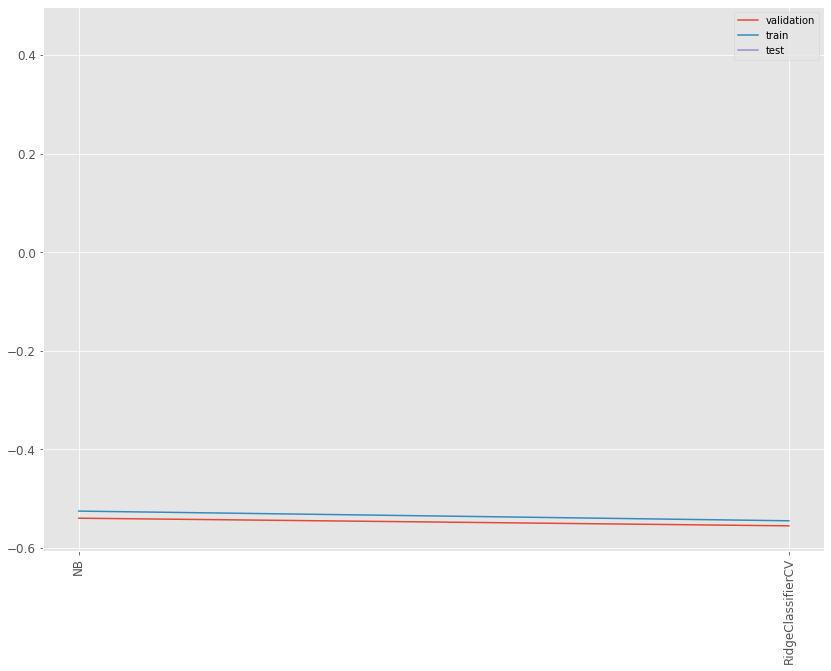

In [ ]:
model_names = []
for model in model_paramGrid_list:
    model_names.append(model[0])

plt.figure(figsize=(14, 10))
plt.plot(models_train_val_score[:, 0], label="validation")
plt.plot(models_train_val_score[:, 1], label="train")
plt.plot(test_score, label="test")
plt.legend()
plt.xticks(range(len(model_names)), model_names, rotation=90)
plt.show()